# Simulating DESI Spectra

The goal of this notebook is to demonstrate how to generate some simple DESI spectra using the `quickspectra` utility.  For simplicity we will only generate 1D spectra and skip the more computationally intensive (yet still instructive!) step of extracting 1D spectra from simulated 2D spectra (i.e., so-called "pixel-level simulations").  In this tutorial we will:

  * generate 100 random QSO spectra
  * simulate them under dark time conditions
  * plot the truth and the noisy simulated spectra
  * run redshift fitting
  * re-simulate when the moon is quite bright
  * re-run redshift fitting
  * compare redshift performance with and without moon

The heart of `quickspectra` is the `SpecSim` package, which you can read about here:  
http://specsim.readthedocs.io/en/stable

If you identify any errors or have requests for additional functionality please create a new issue on  
https://github.com/desihub/desisim/issues
or send a note to <desi-data@desi.lbl.gov>.

## Getting started.

See https://desi.lbl.gov/trac/wiki/Computing/JupyterAtNERSC to configure a jupyter server at NERSC with pre-installed DESI code.  This notebook was tested with the "DESI 18.6" kernel.

Alternately, see https://desi.lbl.gov/trac/wiki/Pipeline/GettingStarted/Laptop for instructions to install code locally.

First, import all the package dependencies.

In [1]:
import os
import numpy as np

import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table

In [2]:
import desispec.io
import desisim.io
import desisim.templates

In [3]:
%matplotlib inline

## Simulate with quickspectra

The simplest way to simulate spectra is using the `quickspectra` script.  We'll generate a set of noiseless template spectra, save them to a file, and then run `quickspectra` to simulate noise and write out a file that can be used as input for redshift fitting.

### Start by simulating some QSO spectra

In [4]:
qso_maker = desisim.templates.QSO()
flux, wave, meta = qso_maker.make_templates(nmodel=100)

What are the outputs?
* `flux[nspec, nwave]` 2D array of flux [1e-17 erg/s/cm2/A]
* `wave[nwave]` 1D array of wavelengths at which flux is sampled
* `meta` table of basic metadata about the targets; some columns are
  specific to ELGs and don't apply to QSO targets

In [5]:
print('flux.shape', flux.shape)
print('wave.shape', wave.shape)
print('meta.colnames', meta.colnames)

flux.shape (100, 32001)
wave.shape (32001,)
meta.colnames ['OBJTYPE', 'SUBTYPE', 'TEMPLATEID', 'SEED', 'REDSHIFT', 'MAG', 'FLUX_G', 'FLUX_R', 'FLUX_Z', 'FLUX_W1', 'FLUX_W2', 'OIIFLUX', 'HBETAFLUX', 'EWOII', 'EWHBETA', 'D4000', 'VDISP', 'OIIDOUBLET', 'OIIIHBETA', 'OIIHBETA', 'NIIHBETA', 'SIIHBETA', 'ZMETAL', 'AGE', 'TEFF', 'LOGG', 'FEH']


Text(0.5,0,'g magnitude')

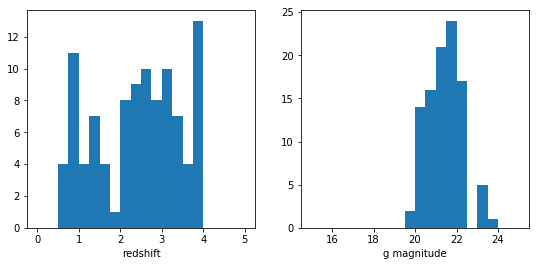

In [6]:
plt.figure(figsize=(9,4))
plt.subplot(121)
plt.hist(meta['REDSHIFT'], 20, (0,5))
plt.xlabel('redshift')

plt.subplot(122)
mag_g = 22.5 - 2.5 * np.log10(meta['FLUX_G'])
plt.hist(mag_g, 20, (15, 25))
plt.xlabel('g magnitude')

### Write those to a file and run quickspectra

In [16]:
simdir = os.path.join(os.environ['SCRATCH'], 'desi', 'simspec')
os.makedirs(simdir, exist_ok=True)
infile = os.path.join(simdir, 'qso-input-spectra.fits')
hdr = fits.Header()
hdr['EXTNAME'] = 'WAVELENGTH'
hdr['BUNIT'] = 'Angstrom'
fits.writeto(infile, wave, header=hdr, overwrite=True)
hdr['EXTNAME'] = 'FLUX'
hdr['BUNIT'] = '10^-17 erg/(s*cm^2*Angstrom)'  # Satisifes FITS standard AND Astropy-compatible.
fits.append(infile, flux, header=hdr)

In [17]:
specoutfile = os.path.join(simdir, 'qso-observed-spectra.fits')
cmd = 'quickspectra -i {} -o {}'.format(infile, specoutfile)
print(cmd)
!$cmd

quickspectra -i /global/cscratch1/sd/bweaver/desi/simspec/qso-input-spectra.fits -o /global/cscratch1/sd/bweaver/desi/simspec/qso-observed-spectra.fits
INFO:quickspectra.py:304:main: Reading an input FITS file
INFO:quickspectra.py:339:main: input flux shape = (100, 32001)
INFO:quickspectra.py:60:sim_spectra: Starting simulation of 100 spectra
DEBUG:simexp.py:408:simulate_spectra: loading specsim desi config desi
DEBUG:simexp.py:412:simulate_spectra: creating specsim desi simulator
INFO:simexp.py:434:simulate_spectra: MJD not in obsconditions, using DATE-OBS 2009-06-18T12:00:00.000
DEBUG:simexp.py:438:simulate_spectra: obsconditions SEEING = 1.1
DEBUG:simexp.py:438:simulate_spectra: obsconditions EXPTIME = 1000.0
DEBUG:simexp.py:438:simulate_spectra: obsconditions AIRMASS = 1.0
DEBUG:simexp.py:438:simulate_spectra: obsconditions MOONFRAC = 0.0
DEBUG:simexp.py:438:simulate_spectra: obsconditions MOONALT = -60
DEBUG:simexp.py:438:simulate_spectra: obsconditions MOONSEP = 180
DEBUG:simexp.

### Let's see what we got

In [18]:
spectra = desispec.io.read_spectra(specoutfile)

In [19]:
from scipy.signal import medfilt
def plotspec(spectra, i, truewave=None, trueflux=None, nfilter=11):
    plt.plot(spectra.wave['b'], medfilt(spectra.flux['b'][i], nfilter), 'b', alpha=0.5)
    plt.plot(spectra.wave['r'], medfilt(spectra.flux['r'][i], nfilter), 'r', alpha=0.5)
    plt.plot(spectra.wave['z'], medfilt(spectra.flux['z'][i], nfilter), 'k', alpha=0.5)
    if truewave is not None and trueflux is not None:
        plt.plot(truewave, trueflux[i], 'k-')

    plt.axhline(0, color='k', alpha=0.2)
        
    ymin = ymax = 0.0
    for x in ['b', 'r', 'z']:
        tmpmin, tmpmax = np.percentile(spectra.flux['r'][i], [1, 99])
        ymin = min(tmpmin, ymin)
        ymax = max(tmpmax, ymax)
        
    plt.ylim(ymin, ymax)
    plt.ylabel('flux [1e-17 erg/s/cm2/A]')
    plt.xlabel('wavelength [A]')

# plotspec(spectra, 0, wave, flux)

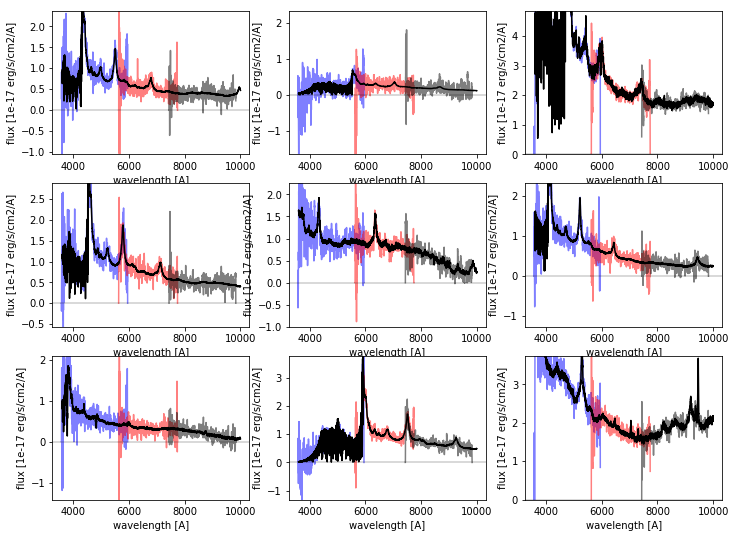

In [20]:
plt.figure(figsize=(12,9))
for i in range(9):
    plt.subplot(3,3,i+1)
    plotspec(spectra, i, wave, flux)

## Fit redshifts

Next well run the redrock redshift fitter (rrdesi) on these spectra.

If at NERSC, run this via an interactive batch node so that we don't abuse the single jupyter server node.

**Note**: if this step doesn't work, check your .bashrc.ext,  .bash_profile.ext, or .tcshrc.ext files to see if you are defining
an incompatible python / desi version that could be overriding the
environment of this notebook after the job is launched.

In [21]:
zoutfile = os.path.join(simdir, 'qso-zbest.fits')
cmd = 'rrdesi {} --zbest {}'.format(specoutfile, zoutfile)
if 'NERSC_HOST' in os.environ:
    print('Running on a batch node:')
    print(cmd)
    print()
    srun = 'srun -A desi -N 1 -t 00:10:00 -C haswell --qos interactive'
    cmd = '{srun} {cmd} --mp 32'.format(srun=srun, cmd=cmd)

!$cmd

Running on a batch node:
rrdesi /global/cscratch1/sd/bweaver/desi/simspec/qso-observed-spectra.fits --zbest /global/cscratch1/sd/bweaver/desi/simspec/qso-zbest.fits

srun: job 13742474 queued and waiting for resources
srun: job 13742474 has been allocated resources
Running with 32 processes
Loading targets...
Read and distribution of 100 targets: 0.9 seconds
DEBUG: Using default redshift range 0.0050-1.6988 for rrtemplate-galaxy.fits
DEBUG: Using default redshift range 0.0500-5.9934 for rrtemplate-qso.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-A.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-B.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-Carbon.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-F.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-G.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-K.fits
DEBUG: Using de

In [22]:
zbest = Table.read(zoutfile, 'ZBEST')

Text(0,0.5,'fitted redshift')

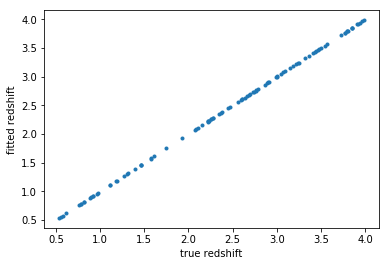

In [23]:
plt.plot(meta['REDSHIFT'], zbest['Z'], '.')
plt.xlabel('true redshift'); plt.ylabel('fitted redshift')

### Re-simulate with the moon up and at a higher airmass

In [24]:
specoutfile_moon = os.path.join(simdir, 'qso-moon-spectra.fits')
cmd = 'quickspectra -i {} -o {} --moonfrac 0.9 --moonalt 70 --moonsep 20 --airmass 1.3'.format(infile, specoutfile_moon)
print(cmd)
!$cmd

quickspectra -i /global/cscratch1/sd/bweaver/desi/simspec/qso-input-spectra.fits -o /global/cscratch1/sd/bweaver/desi/simspec/qso-moon-spectra.fits --moonfrac 0.9 --moonalt 70 --moonsep 20 --airmass 1.3
INFO:quickspectra.py:304:main: Reading an input FITS file
INFO:quickspectra.py:339:main: input flux shape = (100, 32001)
INFO:quickspectra.py:60:sim_spectra: Starting simulation of 100 spectra
DEBUG:simexp.py:408:simulate_spectra: loading specsim desi config desi
DEBUG:simexp.py:412:simulate_spectra: creating specsim desi simulator
INFO:simexp.py:434:simulate_spectra: MJD not in obsconditions, using DATE-OBS 2009-06-18T12:00:00.000
DEBUG:simexp.py:438:simulate_spectra: obsconditions SEEING = 1.1
DEBUG:simexp.py:438:simulate_spectra: obsconditions EXPTIME = 1000.0
DEBUG:simexp.py:438:simulate_spectra: obsconditions AIRMASS = 1.3
DEBUG:simexp.py:438:simulate_spectra: obsconditions MOONFRAC = 0.9
DEBUG:simexp.py:438:simulate_spectra: obsconditions MOONALT = 70.0
DEBUG:simexp.py:438:simulat

In [25]:
zoutfile_moon = os.path.join(simdir, 'qso-zbest-moon.fits')
cmd = 'rrdesi {} --zbest {}'.format(specoutfile_moon, zoutfile_moon)
if 'NERSC_HOST' in os.environ:
    print('Running on a batch node:')
    print(cmd)
    print()
    srun = 'srun -A desi -N 1 -t 00:10:00 -C haswell --qos interactive'
    cmd = '{srun} {cmd} --mp 32'.format(srun=srun, cmd=cmd)

print(cmd)
!$cmd

Running on a batch node:
rrdesi /global/cscratch1/sd/bweaver/desi/simspec/qso-moon-spectra.fits --zbest /global/cscratch1/sd/bweaver/desi/simspec/qso-zbest-moon.fits

srun -A desi -N 1 -t 00:10:00 -C haswell --qos interactive rrdesi /global/cscratch1/sd/bweaver/desi/simspec/qso-moon-spectra.fits --zbest /global/cscratch1/sd/bweaver/desi/simspec/qso-zbest-moon.fits --mp 32
srun: job 13742746 queued and waiting for resources
srun: job 13742746 has been allocated resources
Running with 32 processes
Loading targets...
Read and distribution of 100 targets: 0.9 seconds
DEBUG: Using default redshift range 0.0050-1.6988 for rrtemplate-galaxy.fits
DEBUG: Using default redshift range 0.0500-5.9934 for rrtemplate-qso.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-A.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-B.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-Carbon.fits
DEBUG: Using default redshift range -0.0

In [26]:
zbest_moon = Table.read(zoutfile_moon, 'ZBEST')

Text(0.5,0,'true redshift')

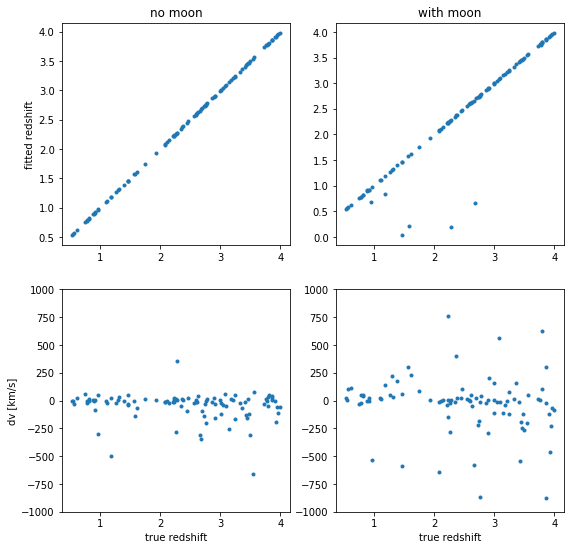

In [27]:
plt.figure(figsize=(9,9))

plt.subplot(221)
plt.plot(meta['REDSHIFT'], zbest['Z'], '.')
plt.ylabel('fitted redshift')
plt.title('no moon')

plt.subplot(222)
plt.plot(meta['REDSHIFT'], zbest_moon['Z'], '.')
plt.title('with moon')

plt.subplot(223)
dv = 3e5*(zbest['Z'] - meta['REDSHIFT'])/(1+meta['REDSHIFT'])
plt.plot(meta['REDSHIFT'], dv, '.')
plt.ylim(-1000, 1000)
plt.ylabel('dv [km/s]')
plt.xlabel('true redshift')

plt.subplot(224)
dv = 3e5*(zbest_moon['Z'] - meta['REDSHIFT'])/(1+meta['REDSHIFT'])
plt.plot(meta['REDSHIFT'], dv, '.')
plt.ylim(-1000, 1000)
plt.xlabel('true redshift')

Unsurprisingly, it is harder to fit a redshift on a spectrum polluted with a lot of moonlight

## Exercises

Run `help(qso_maker.make_templates)` to see what other options
are available for generating QSO templates.  Try adjusting the magnitude
or redshift ranges and resimulating

This tutorial used `desisim.templates.QSO()` to generate QSO templates.  There are also template generators for ELG, LRG, BGS, FSTD, MWS_STAR, STAR, WD; run `help(desisim.templates)` for details.  Try generating
other template classes and studying their redshift efficiency.

Simulate more QSOs and study their efficiency vs. S/N or g-band magnitude.

## Appendix: Code versions

In [28]:
from desitutorials import print_code_versions
print("This tutorial last ran successfully to completion using the following versions of the following modules:") 
print_code_versions()

This tutorial last ran successfully to completion using the following versions of the following modules:
python      : 3.6.6
numpy       : 1.13.3
scipy       : 1.1.0
astropy     : 2.0.7
yaml        : 3.12
matplotlib  : 2.1.2
fitsio      : 0.9.11
healpy      : 1.11.0
desiutil    : 1.9.11
desispec    : 0.22.1
desitarget  : 0.21.0
desimodel   : 0.9.6
desisim     : 0.28.0
speclite    : 0.7


## Appendix: other spectro simulators

This tutorial focused on quickspectra, which simulates spectra outside of the context
of the full spectroscopic pipeline.  A separate tutorial (from June 2016, possibly out-of-date)
covers the use of `quickgen` which can write out intermediate pipeline steps, e.g. non-skysubtracted
non-fluxcalibrated spectra, and then proceed with the real spectro pipeline.  That method is
mostly for people working on developing the spectro pipeline itself.

Under the hood of both of these is [specsim](http://specsim.readthedocs.io/en/stable), which has many more options, e.g. for adjusting input fiberloss fractions based upon object sizes.  See the [specsim tutorials](https://github.com/desihub/specsim/tree/master/docs/nb) for details.

Lastly, the [minitest notebook](https://github.com/desihub/desitest/blob/master/mini/minitest.ipynb) in the [desitest](https://github.com/desihub/desitest) has instructions for the full end-to-end chain covering survey simulations, mocks, fiber assignment, spectral simulation, running the DESI spectro pipeline, and ending with a redshift catalog.  But that takes ~2 hours to run and consumes ~1500 MPP hours at NERSC, so it is primarily used for reference and integration testing.